# Predicting Graduate School Admission Rate 

### Using Bayesian Machine Learning for prediction  and Markov Chain Monte Carlo in pymc3 for sampling 

[I. EDA](#eda)

[II. Traditional Machine Learning](#traditional)
- [Random Forest](#rf)
- [Linear Regression](#linear)
- [Elastic Net](#elastic)

[II. Bayesian Machine Learning](#bayes)
- [Bayseian Linear Regression](#blg)
- [Complete pool model](#pool)
- [Unpool model](#unpool)                             
- [Hierarchical model](#heirarchical)

[IV. Model Comparison](#compare)
- [Intercept and slope](#i&s)
- [Mean and Standard Deviation](#mean)
- [WAIC Score](#waic)


### Problem Statement

Admission rate is determined based on 7 variables, GRE score, TOEFL score, university rating, statement of purpose, letters of recommendation, undergraduate CGPA, and whether the student has research experience or not. To be specific, the probability of admission has been determined by each school's admission system. The goal of the project is to predict admission rate under supervised regression and draw useful inference using Bayesian method. We will compare the Bayesian Linear Regression method to several other traditional machine learning approaches. Furthermore, we will group data by university rating to get better prediction on each group. We will also compare model performance of complete pooling, unpooled and hierarchical model with WAIC score. <br>
The result will be useful for students who plan to apply for graduate school, especially UCLA. 

### Dataset
The data was collected from UCLA Graduate School Admission on [Kaggle](https://www.kaggle.com/mohansacharya/graduate-admissions). The target variable to predict is **Chance of Admit**. There are 7 features, which we keep all of them in future analysis regardless of correlation because of less amount of features. We treat GRE Score, TOEFL Score, GPA, SOP and LOP as numerical features, and Research, University Rating as categorical variables.(Noted that University Rating 5 indicates highest rating)


<img src='https://github.com/elletsai/bayesian-project/blob/master/data/data_description.png?raw=true' style="width: 500px;">


In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib.patches import Ellipse
import numpy as np
import pandas as pd
import pymc3 as pm
from pymc3.distributions import draw_values
from pymc3.distributions.dist_math import bound
from pymc3.math import logsumexp
import scipy as sp
import seaborn as sns
from theano import shared, tensor as tt
from sklearn.model_selection import train_test_split
from pymc3 import Model, sample, Normal, HalfCauchy, Uniform, model_to_graphviz
import graphviz
import arviz as az

In [21]:
%matplotlib inline
plt.style.use('bmh')
colors = ['#348ABD', '#A60628', '#7A68A6', '#467821', '#D55E00', 
          '#CC79A7', '#56B4E9', '#009E73', '#F0E442', '#0072B2']


# <a name = eda></a>EDA
### Data Preparation
We use pandas_profiling package to get basic descriptive analysis including data distribution and correlation. Also, we checked our dataset for missing value.

In [264]:
# read csv file
admission = pd.read_csv("https://raw.githubusercontent.com/elletsai/bayesian-project/master/data/Admission_Predict.csv")

In [3]:
admission.head()

Serial No.  GRE Score  TOEFL Score  University Rating  SOP  LOR   CGPA  \
0           1        337          118                  4  4.5   4.5  9.65   
1           2        324          107                  4  4.0   4.5  8.87   
2           3        316          104                  3  3.0   3.5  8.00   
3           4        322          110                  3  3.5   2.5  8.67   
4           5        314          103                  2  2.0   3.0  8.21   

   Research  Chance of Admit   
0         1              0.92  
1         1              0.76  
2         1              0.72  
3         1              0.80  
4         0              0.65

In [240]:
# pandas_profiling can provide basic descriptive analysis for understanding features distribution and correlation"
import pandas_profiling 
pandas_profiling.ProfileReport(admission)

In [17]:
pfr = pandas_profiling.ProfileReport(admission)
pfr.to_file('report.html')

In [4]:
# check dataset to see if there is NA value
admission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 9 columns):
Serial No.           500 non-null int64
GRE Score            500 non-null int64
TOEFL Score          500 non-null int64
University Rating    500 non-null int64
SOP                  500 non-null float64
LOR                  500 non-null float64
CGPA                 500 non-null float64
Research             500 non-null int64
Chance of Admit      500 non-null float64
dtypes: float64(4), int64(5)
memory usage: 35.3 KB


In [5]:
# rename column
admission = admission.rename(columns={'University Rating':'University_Rating',
                                     'Chance of Admit ':'Chance_of_Admit_',
                                     'Serial No.':'Serial_No.',
                                     'GRE Score' :'GRE_Score',
                                     'TOEFL Score': 'TOEFL_Score'})

In [6]:
admission['University_Rating'] = admission['University_Rating'].astype('category',copy=True)

In [7]:
admission.head()

Serial_No.  GRE_Score  TOEFL_Score University_Rating  SOP  LOR   CGPA  \
0           1        337          118                 4  4.5   4.5  9.65   
1           2        324          107                 4  4.0   4.5  8.87   
2           3        316          104                 3  3.0   3.5  8.00   
3           4        322          110                 3  3.5   2.5  8.67   
4           5        314          103                 2  2.0   3.0  8.21   

   Research  Chance_of_Admit_  
0         1              0.92  
1         1              0.76  
2         1              0.72  
3         1              0.80  
4         0              0.65

### Draw KDE
In order to understand the distribution of data's likelihood, we drew kde and histogram to get the information. As you can see, numerical features had a Gaussian pattern, and categorical features showed Binomial distribution.

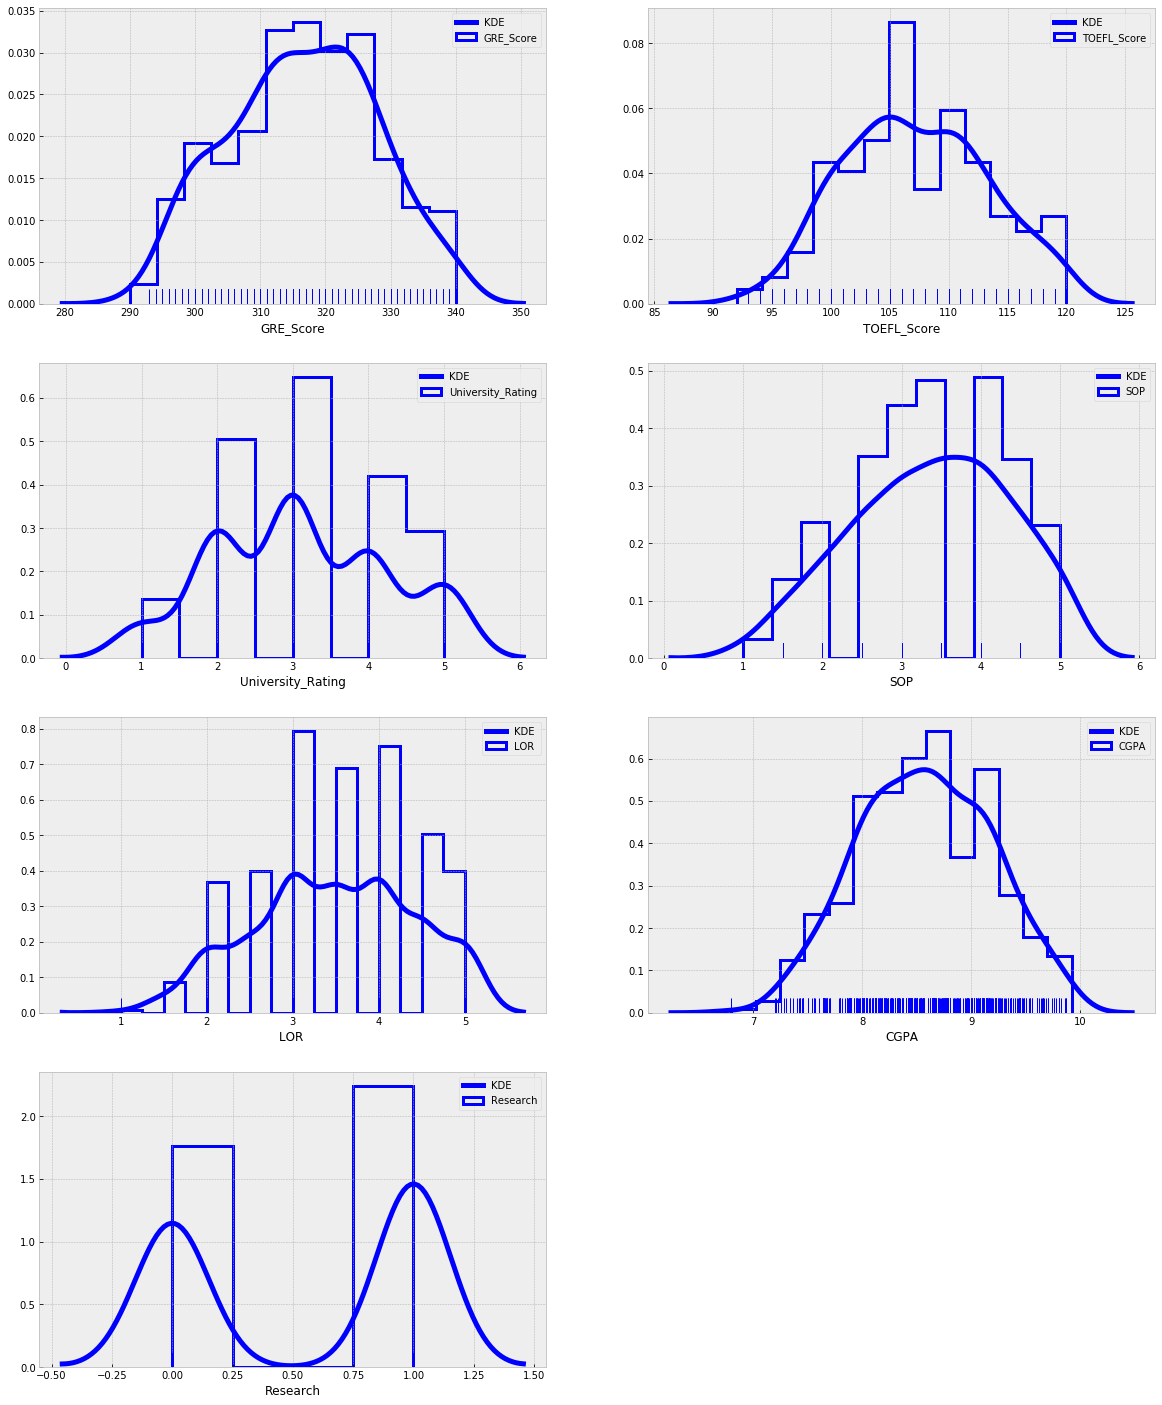

In [130]:
plt.figure(figsize=(20,25))

i = 0

for item in admission.columns[1:-1]:
    i += 1
    plt.subplot(4, 2, i)
    sns.distplot(admission[item], rug=True, rug_kws={"color": "b"},kde=True,
                 kde_kws={"color": "blue", "lw": 5, "label": "KDE"},
                 hist_kws={"histtype": "step", "linewidth": 3,"alpha": 1, "color": "blue"},label="{0}".format(item))
plt.show()


# <a name = traditional></a>Traditional Machine Learning

We try several standard machine learning methods to compare with Bayesian Linear Regression. We apply following's model:<br>
- Random Forest
- Linear Regression
- Elastic Net Linear Regression with an L1 ratio of 0.5

### <a name = rf></a>Random Forest
We utlilize random forest package developed from [H2o.ai](http://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/drf.html) and calculated the model performace. Since h2o random forest package can deal with categorical Also, we estimate the feature importance showing that GRE Score, TOEFL Score, and GPA. 

In [ ]:
import h2o
from h2o.estimators.random_forest import H2ORandomForestEstimator
h2o.init()

In [10]:
y = 'Chance_of_Admit_'
x = list(admission.columns)
x.remove(y)
x.remove('Serial_No.')

In [11]:
rf_train, rf_test = train_test_split(admission.iloc[:,1:], test_size = 0.25, random_state=42)
rf_train.head()

GRE_Score  TOEFL_Score University_Rating  SOP  LOR   CGPA  Research  \
227        312          110                 2  3.5   3.0  8.53         0   
417        316          103                 3  3.5   2.0  7.68         0   
203        334          120                 5  4.0   5.0  9.87         1   
126        323          113                 3  4.0   3.0  9.32         1   
329        297           96                 2  2.5   1.5  7.89         0   

     Chance_of_Admit_  
227              0.64  
417              0.52  
203              0.97  
126              0.85  
329              0.43

In [12]:
ad_h2o = h2o.H2OFrame(rf_train)
ad_h2o_test = h2o.H2OFrame(rf_test)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [13]:
ad_h2o_test.shape

(125, 8)

In [14]:
# Initialize the RF estimator:
h2o_rf = H2ORandomForestEstimator(model_id='h2o_rf', seed=1, nfolds=10)
h2o_rf.train(x=x, y=y, training_frame = ad_h2o)

drf Model Build progress: |███████████████████████████████████████████████| 100%


In [15]:
h2o_predict = h2o_rf.predict(ad_h2o_test)

drf prediction progress: |████████████████████████████████████████████████| 100%


In [18]:
# include the prediction of h2o random forest to the testing dataset
rf_test.reset_index(drop=True, inplace=True)
rf_test['predict'] = h2o_predict.as_data_frame()
rf_test.head()

GRE_Score  TOEFL_Score University_Rating  SOP  LOR   CGPA  Research  \
0        334          116                 4  4.0   3.5  9.54         1   
1        314          108                 4  4.5   4.0  9.04         1   
2        315          105                 2  2.0   2.5  7.65         0   
3        312          109                 3  3.0   3.0  8.69         0   
4        326          112                 3  3.5   3.0  9.05         1   

   Chance_of_Admit_   predict  
0              0.93  0.929300  
1              0.84  0.767600  
2              0.39  0.620100  
3              0.77  0.702100  
4              0.74  0.805483

In [19]:
h2o_rf.model_performance(test_data=ad_h2o_test)


ModelMetricsRegression: drf
** Reported on test data. **

MSE: 0.003951100390370069
RMSE: 0.06285777907602264
MAE: 0.04545549086570738
RMSLE: 0.03861635003614309
Mean Residual Deviance: 0.003951100390370069


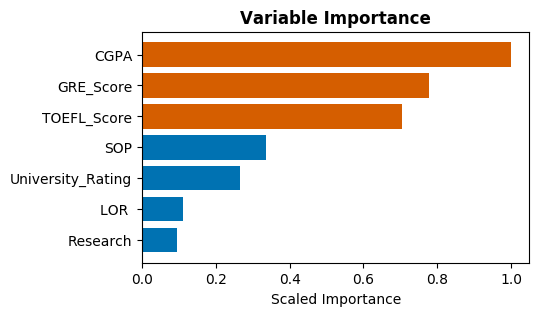

In [22]:
# Show feature importance
import matplotlib.pyplot as plt
plt.rcdefaults()
fig, ax = plt.subplots(figsize = (5, 3))


variables = h2o_rf._model_json['output']['variable_importances']['variable']
y_pos = np.arange(len(variables))
scaled_importance = h2o_rf._model_json['output']['variable_importances']['scaled_importance']
ax.barh(y_pos, scaled_importance, align='center', color=(colors[4], colors[4], colors[4], colors[9], colors[9],
                                                        colors[9], colors[9], colors[9]), ecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(variables)
ax.invert_yaxis()
ax.set_xlabel('Scaled Importance')
ax.set_title('Variable Importance',fontweight="bold")


fig = plt.gcf() # to get the current figure...
fig.savefig("feature_importance.png") # and save it directly


plt.show()



### Splitting data to training set/ testing set and convert categorical features to dummies
We divided the dataset into training and testing data and transform categorical data to dummies. Also we calculate the correlation between University rating and Chance of Admit. We notice that before splitting University Rating, it has positive correlation with Chance of Admit. However, after splitting different groups, low university rating may have negative correlation with admission rate.

In [23]:
# Since Serial_No. is just the number of each row, drop it before fitting models
df2 = admission.drop(columns = ['Serial_No.']) 

In [24]:
# correlation (only numeric variable)
admission.corr()['Chance_of_Admit_'].sort_values()

Serial_No.          0.008505
Research            0.545871
LOR                 0.645365
SOP                 0.684137
TOEFL_Score         0.792228
GRE_Score           0.810351
CGPA                0.882413
Chance_of_Admit_    1.000000
Name: Chance_of_Admit_, dtype: float64

In [25]:
#correlation after one hot encoding (including dummy variables)
df2=pd.get_dummies(df2) 
df2.corr()['Chance_of_Admit_']

GRE_Score              0.810351
TOEFL_Score            0.792228
SOP                    0.684137
LOR                    0.645365
CGPA                   0.882413
Research               0.545871
Chance_of_Admit_       1.000000
University_Rating_1   -0.305903
University_Rating_2   -0.393661
University_Rating_3   -0.092499
University_Rating_4    0.292087
University_Rating_5    0.487790
Name: Chance_of_Admit_, dtype: float64

If university rating is 1,2 or 3, it is negatively correlated with change of admit

In [26]:
# Spit the data to training and testing set

from sklearn.model_selection import train_test_split
df_y = admission['Chance_of_Admit_'] # Target variable

df = admission.drop(columns = ['Serial_No.','Chance_of_Admit_']) 


df=pd.get_dummies(df) # one-hot encoding for "University_Rating_"
df = df.drop(columns = 'University_Rating_1')

# Scale five numerical features
x_num = df.iloc[:,0:5]
meanx = x_num.mean().values
stdx = x_num.std().values
x_num_scaled = ((x_num-meanx)/stdx).values
df.iloc[:,0:5] = x_num_scaled
df.head()
X_train1, X_test1, y_train1, y_test1 = train_test_split(df, df_y, test_size = 0.25, random_state=42)


### <a name = linear></a>Linear Regression
We fit linear regression model from sklearn, and show the linear equation. Also, we analyze the rmse to compare model performance with other machine learning models

In [241]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error

def linear_reg(X_train1, y_train1, X_test1, y_test1):
    #Fit a linear regression on the training data
    lin_reg = LinearRegression()
    lin_reg.fit(X_train1, y_train1)

    # Model parameters
    intercept = lin_reg.intercept_
    coefs = lin_reg.coef_

    # Write the final equation
    final_equation = 'grade = %0.4f + ' % intercept

    for var, weight in zip(X_train1.columns, coefs):
        final_equation += '%0.2f * %s + ' % (weight, var)

    final_equation = ' '.join(final_equation.split(' ')[:-2])

    # Display the equation
    print('Final Equation from Standard (OLS) Linear Regression:\n')
    print(final_equation)

    lin_reg.fit(X_train1, y_train1)
    predictions = lin_reg.predict(X_test1)

            # Metrics
    mse = mean_squared_error(y_test1, predictions)
    rmse = np.sqrt(mse)
    linear_rmse = rmse
    print(f'\nlinear rmse:{rmse}')
    
linear_reg(X_train1, y_train1, X_test1, y_test1)

Final Equation from Standard (OLS) Linear Regression:

grade = 0.7156 + 0.02 * GRE_Score + 0.02 * TOEFL_Score + 0.00 * SOP + 0.02 * LOR  + 0.07 * CGPA + 0.02 * Research + -0.01 * University_Rating_2 + -0.01 * University_Rating_3 + -0.01 * University_Rating_4 + 0.01 * University_Rating_5

linear rmse:0.0598161399695965


### <a name = elastic></a>Elastic Model

In [242]:

elastic_model = ElasticNet(alpha=1.0, l1_ratio=0.5)
elastic_model.fit(X_train1, y_train1)
predictions = elastic_model.predict(X_test1)

# calculate mse
elastic_mse = mean_squared_error(y_test1, predictions)
elastic_rmse = np.sqrt(mse)
elastic_rmse

0.0598161399695965

## <a name = bayes></a>Bayesian Regression
### Treat "Research" as boolean, "University_Rating" as categorical feature, other features as multi-Gaussian
Since Research and University Rating has a Binomial distribution, therefore, we choose beta as the conjugate prior. Also, we fit our numerical variables with multi-Gaussian distribution prior. 

### <a name = blg></a>Bayesian Linear Regression

In [ ]:
# seperate numerical and categorical dataset
xtrain_num = X_train1.iloc[:,0:5].values
xtrain_cat = X_train1.iloc[:,5:].values
y_train1 = y_train1.values


In [35]:
with pm.Model() as model1:
    
    beta0 = pm.Normal('beta0', mu=0, sd=1)
    beta_num = pm.MvNormal('beta_num', mu=np.zeros(5), cov=np.identity(5), shape=(5))
    beta_cat = pm.Beta('beta_cat',alpha=[1,1,1,1,1], beta=[1,1,1,1,1], shape=(5))

    
    mu =  beta0+ pm.math.dot(beta_num, xtrain_num.T) + pm.math.dot(beta_cat,xtrain_cat.T)
    sigma = HalfCauchy('sigma', 5)
    
    likelihood = pm.Normal('likelihood', mu=mu, sigma=sigma, observed=y_train1)
    # save trace sample
    db = pm.backends.Text('beta_normal')
 


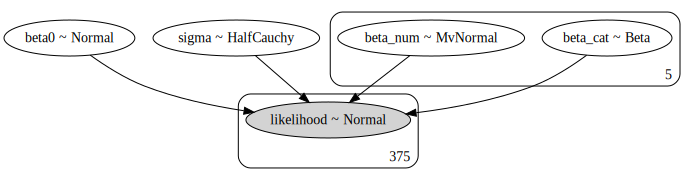

In [36]:
model_to_graphviz(model1)

In [37]:
with model1:
    # start from MAP can make the whole sample set more close to real data
    start = pm.find_MAP()
    trace1 = pm.sample(100000, start = start, nuts_kwargs={'target_accept': 0.95}, trace = db)  # cores = 4,

/Users/ellesmac/anaconda3/lib/python3.7/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = 514.15, ||grad|| = 2.1649: 100%|██████████| 110/110 [00:00<00:00, 984.43it/s]  
Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc3:Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta_cat, beta_num, beta0]
INFO:pymc3:NUTS: [sigma, beta_cat, beta_num, beta0]
Sampling 2 chains: 100%|██████████| 201000/201000 [14:04<00:00, 237.92draws/s]


In [95]:
with model1:
    step = pm.Metropolis() # Have a choice of samplers
    trace1_mp = pm.sample(100000, step, progressbar=True)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [beta_cat]
>Metropolis: [beta_num]
>Metropolis: [beta0]
Sampling 2 chains: 100%|██████████| 201000/201000 [01:43<00:00, 1951.39draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


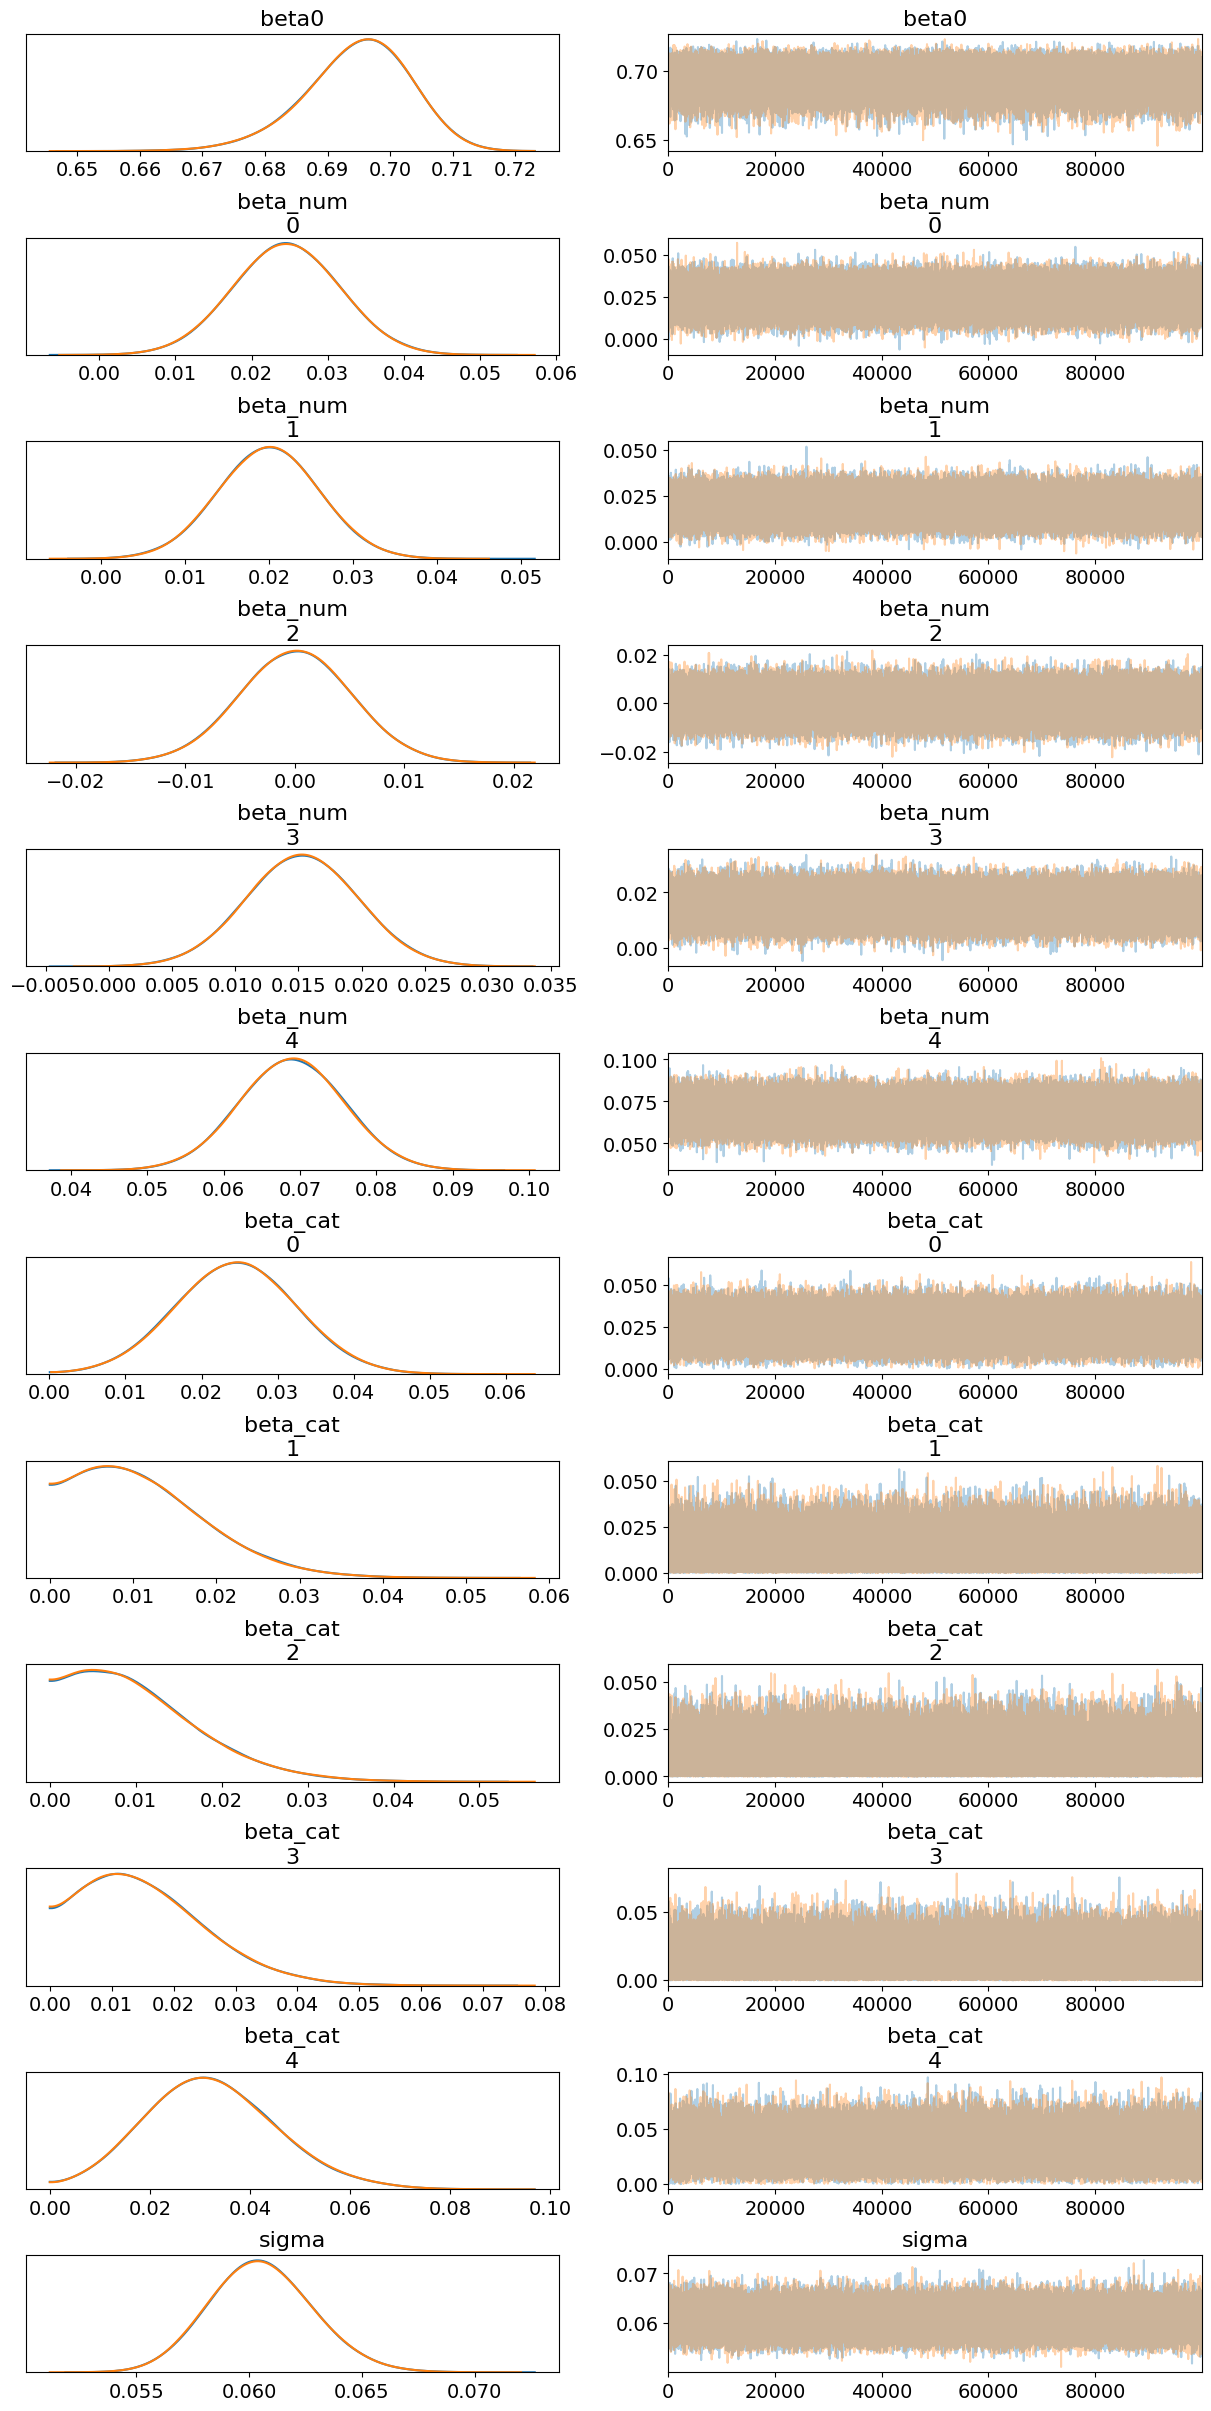

In [38]:
pm.traceplot(trace1);

- From forest plot, we can see the uncertainty of each parameters is small


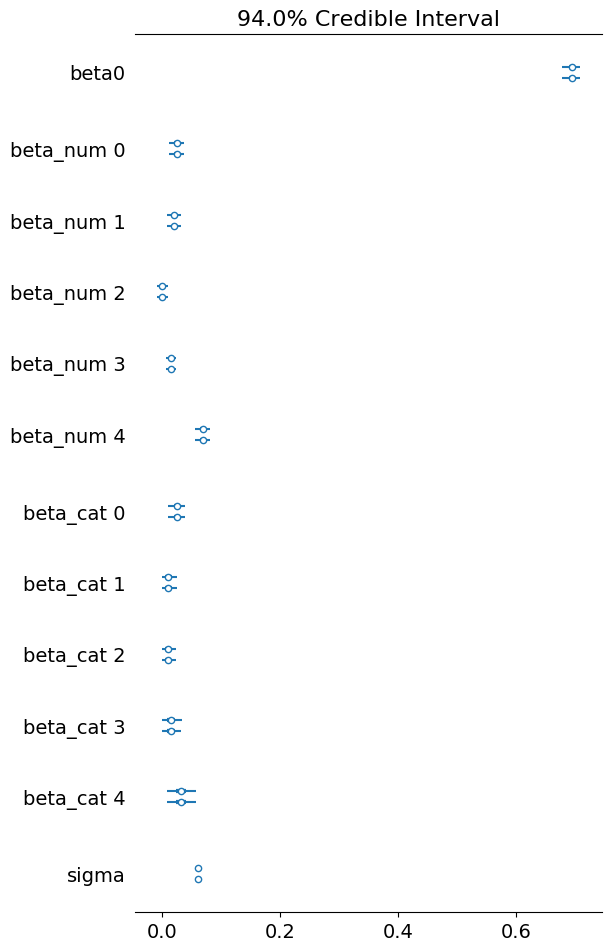

In [40]:
pm.forestplot(trace1);

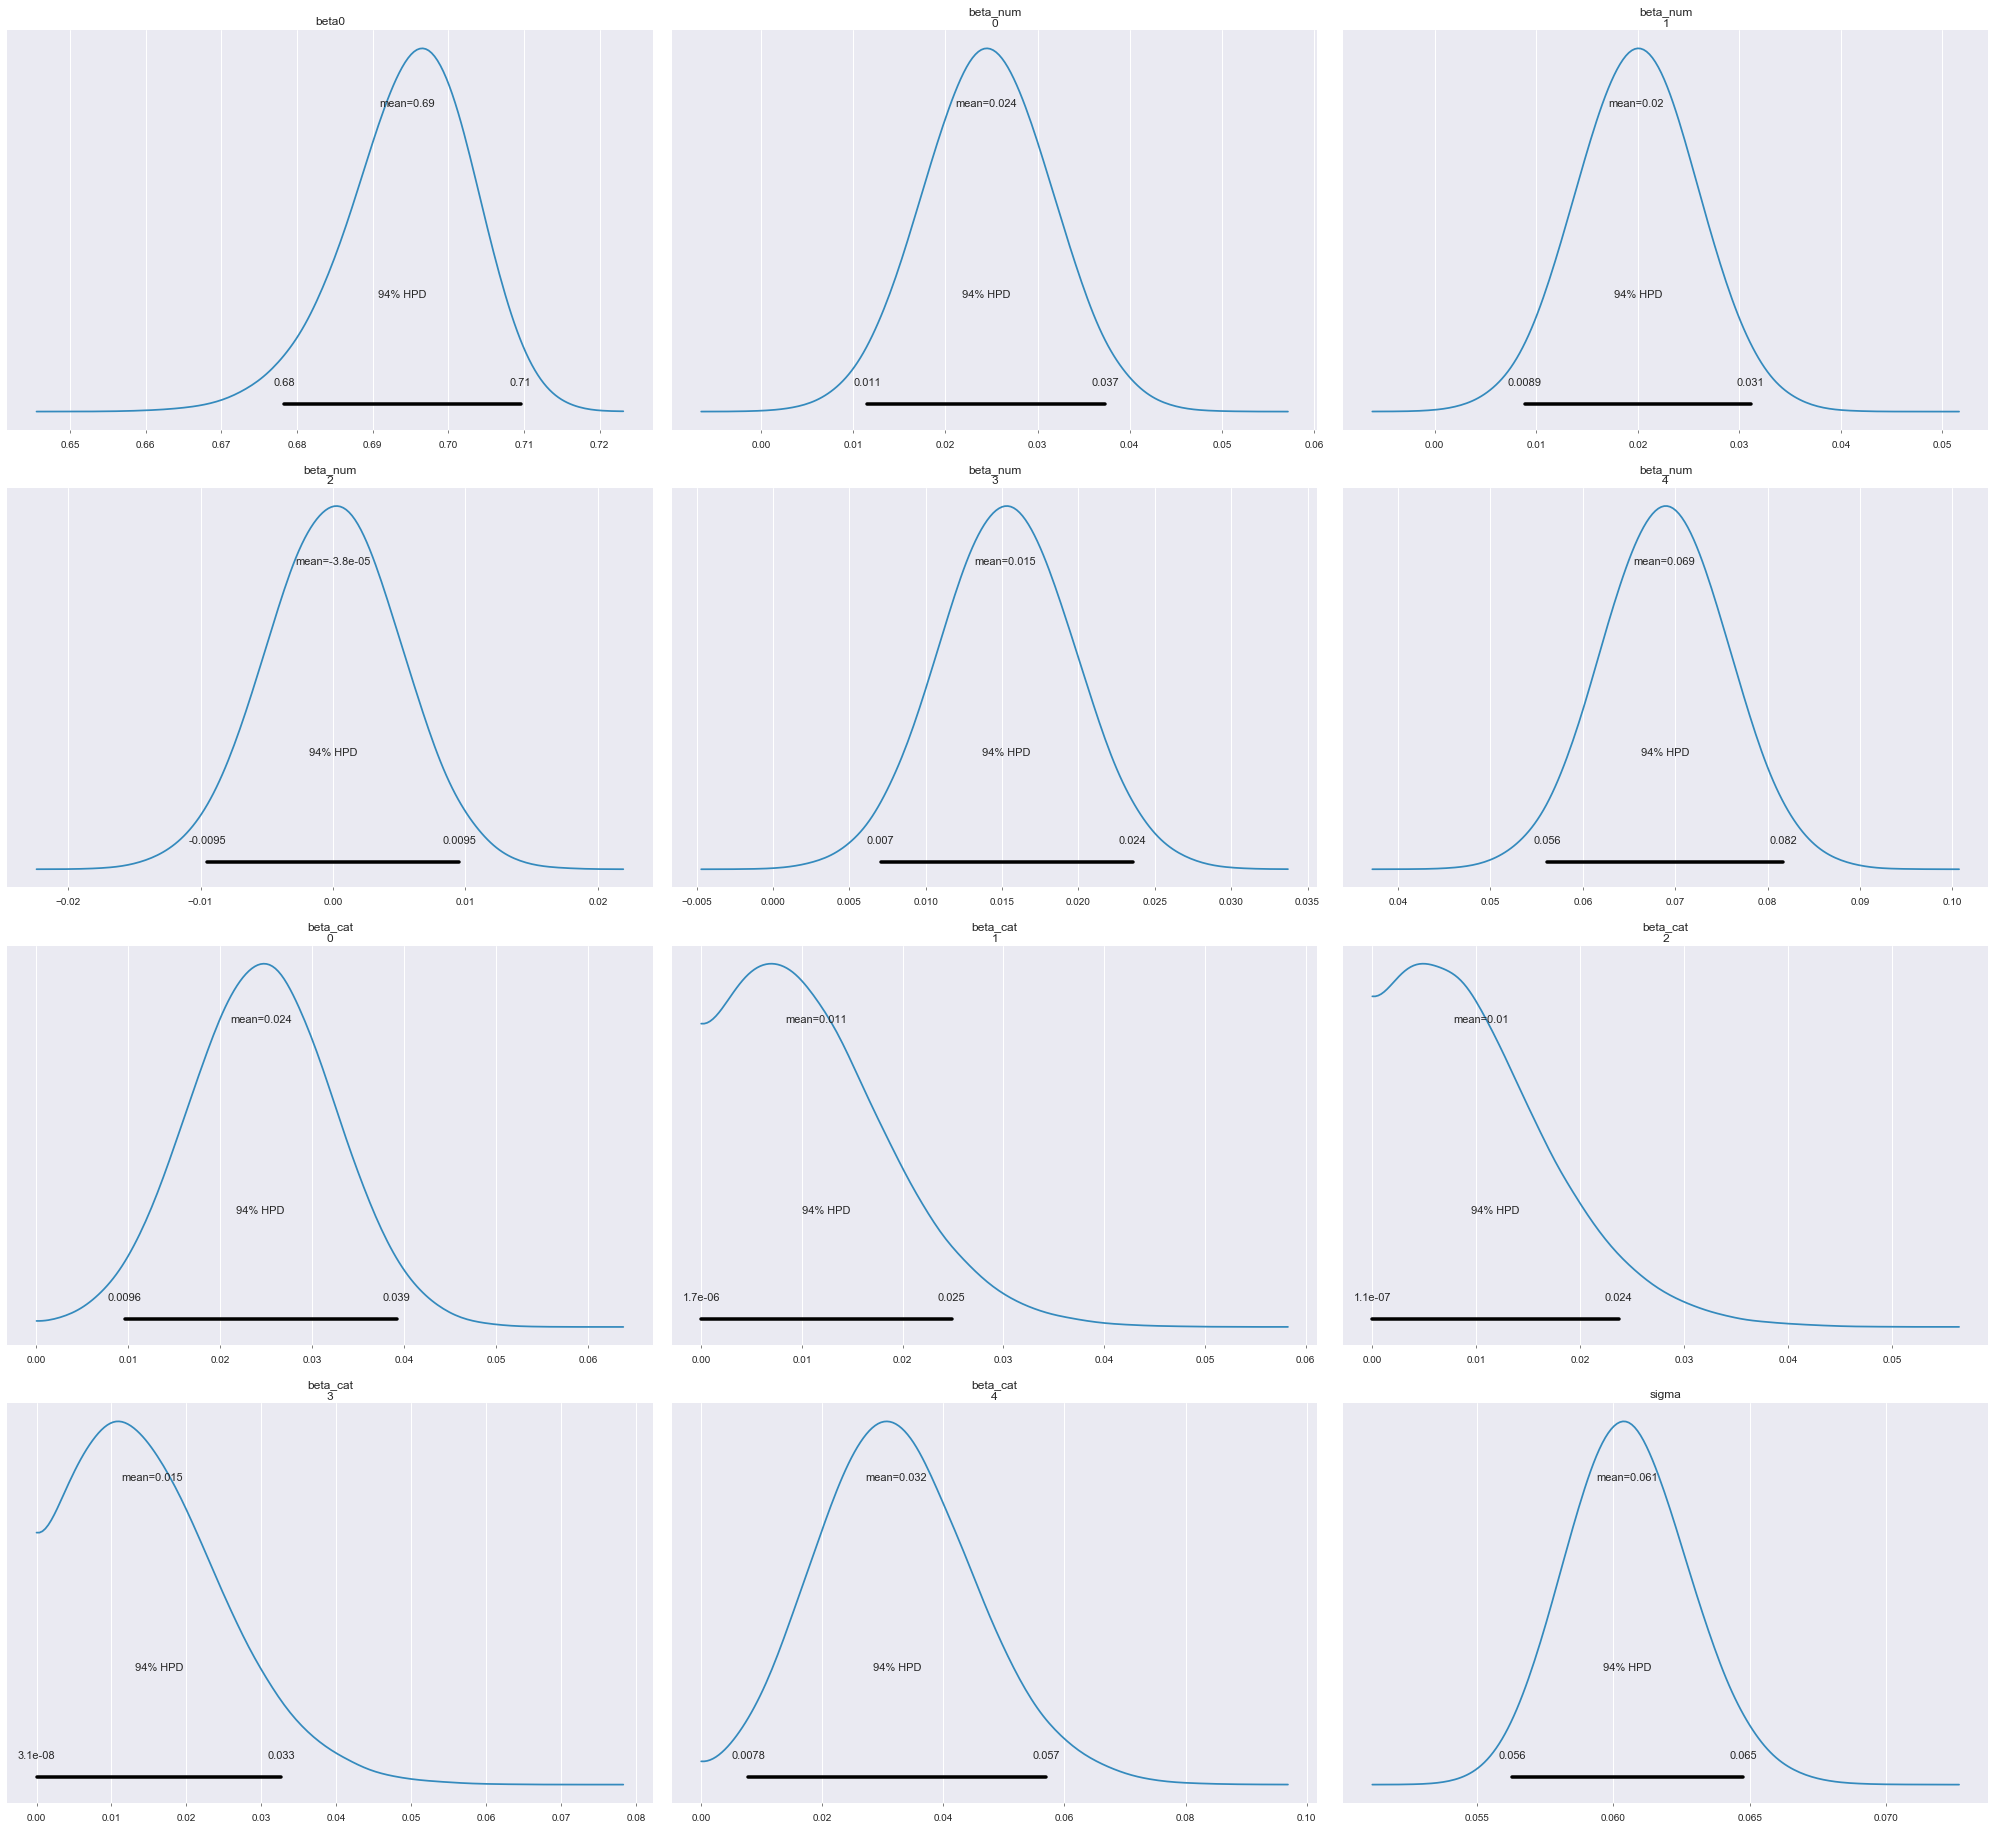

In [243]:
pm.plot_posterior(trace1);

In [42]:
map_estimate = pm.find_MAP(model=model1)

map_estimate

/Users/ellesmac/anaconda3/lib/python3.7/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = 514.15, ||grad|| = 2.1649: 100%|██████████| 110/110 [00:00<00:00, 1302.35it/s] 


{'beta0': array(0.71807396),
 'beta_num': array([0.03122158, 0.01914119, 0.00111886, 0.0161528 , 0.06958508]),
 'beta_cat_logodds__': array([-39.65456773, -11.81577592,  -7.96265043,  -5.54538078,
         -3.84442624]),
 'sigma_log__': array(-2.81091252),
 'beta_cat': array([6.00122697e-18, 7.38704101e-06, 3.48107714e-04, 3.89026256e-03,
        2.09503657e-02]),
 'sigma': array(0.06015008)}

In [43]:
beta_map_est =np.array([0.7225, 0.03342452, 0.01691233, 0.00336232, 0.01229123, 0.06452208,4.97168049e-14,
                        2.63784144e-05,0.00667802,0.00943762, 0.02710066])
beta_map_est

array([7.22500000e-01, 3.34245200e-02, 1.69123300e-02, 3.36232000e-03,
       1.22912300e-02, 6.45220800e-02, 4.97168049e-14, 2.63784144e-05,
       6.67802000e-03, 9.43762000e-03, 2.71006600e-02])

- SOP has 95% hpd that goes from negative to positive meaning that we are not sure whether this feature effect in the model positively or negatively. Fortunately, from the posterior plot and the summary, we notice that beta_num_2 which is the coefficient of SOP is closely to 0, which means that SOP have small influence on the admission rate.

In [52]:
pm.summary(trace1)

/Users/ellesmac/anaconda3/lib/python3.7/site-packages/pymc3/stats.py:991: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


mean        sd  mc_error       hpd_2.5  hpd_97.5  \
beta0        0.694504  0.008301  0.000102  6.784918e-01  0.710554   
beta_num__0  0.024539  0.006884  0.000054  1.126738e-02  0.038078   
beta_num__1  0.019720  0.005950  0.000042  8.089912e-03  0.031387   
beta_num__2  0.000001  0.005001  0.000037 -9.679420e-03  0.009875   
beta_num__3  0.015214  0.004329  0.000028  6.554999e-03  0.023595   
beta_num__4  0.068708  0.006743  0.000047  5.532686e-02  0.081722   
beta_cat__0  0.024413  0.007794  0.000073  9.436602e-03  0.039880   
beta_cat__1  0.011429  0.007592  0.000074  3.640793e-07  0.025668   
beta_cat__2  0.010444  0.007430  0.000082  2.641729e-08  0.024409   
beta_cat__3  0.015473  0.009900  0.000108  8.403711e-06  0.033587   
beta_cat__4  0.032227  0.012998  0.000135  6.623818e-03  0.057296   
sigma        0.060487  0.002236  0.000014  5.619349e-02  0.064969   

                    n_eff      Rhat  
beta0         7595.233304  1.000557  
beta_num__0  18225.135659  1.000205  
beta_num__1  22206.047081  0.999996  
beta_num__2  19127.505039  0.999961  
beta_num__3  21986.018016  1.000048  
beta_num__4  19679.584022  0.999995  
beta_cat__0  11851.079203  1.000052  
beta_cat__1  10461.270807  1.000667  
beta_cat__2   8383.685188  1.000486  
beta_cat__3   8213.033490  1.000004  
beta_cat__4   8542.377450  1.000081  
sigma        23125.047437  0.999950

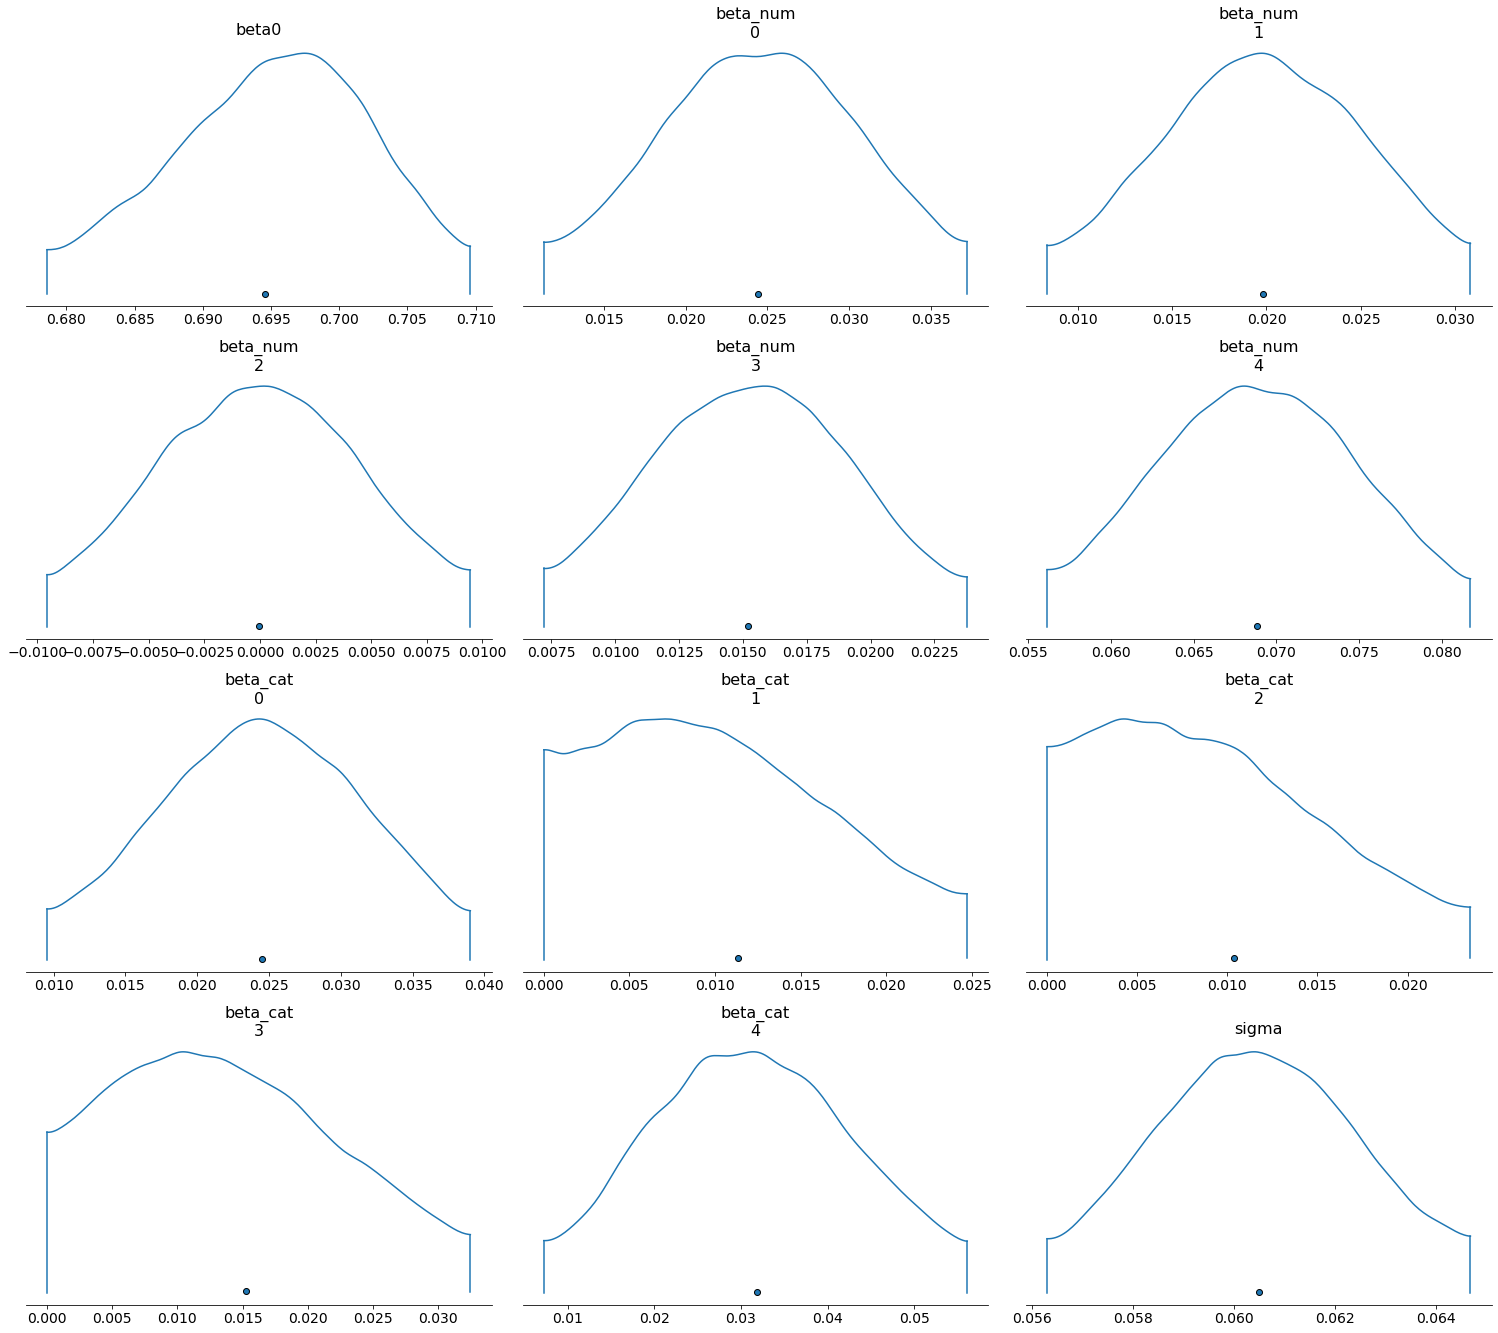

In [45]:
pm.densityplot(trace1);

### Calulate waic to see the model performace
Small waic indicates better model performance

In [43]:
waic = az.waic(trace1)
waic

Computed from 20000 by 375 log-likelihood matrix

        Estimate       SE
IC_waic -1093.85    42.27
p_waic     13.08        -

### Caluclate RMSE for Bayesian Linear Model
We calculate the RMSE for Bayesian Regression Model to compare against standard machine learning method. Also, from the joint distribution, we can see the estimate y and true y follows the diagonal line indicating that our model did well on the prediction.

In [246]:
# Evaluate the performance of Sampling method by RMSE
def evaluate_trace(trace, X_test, y_test):
    beta = pm.summary(trace)[['mean']].iloc[:11,].values
    beta0_hat = beta[0]
    betaj_hat = beta[1:]
    y_hat = beta0_hat+np.dot(betaj_hat.T,X_test.T)
    
    # Plot the observations and predictions
    plt.figure(figsize=(12,12))

    dict_y={'y_test':y_test1, 'y_hat':y_hat.ravel()}
    df_y=pd.DataFrame(dict_y)

    g=sns.jointplot(x='y_test', y='y_hat' , data=df_y, kind='kde')
    x0, x1 = g.ax_joint.get_xlim()
    y0, y1 = g.ax_joint.get_ylim()
    lims = [max(x0, y0), min(x1, y1)]
    g.ax_joint.plot(lims, lims, ':r')  
    
    plt.xlabel('Observed y'); plt.ylabel('Estimated y');
    plt.title('Observed and Estimated Values')
    plt.show()
    

    rmse = np.sqrt(np.sum((y_hat - y_test.values)**2)/len(y_test))
    return rmse
    


<Figure size 864x864 with 0 Axes>

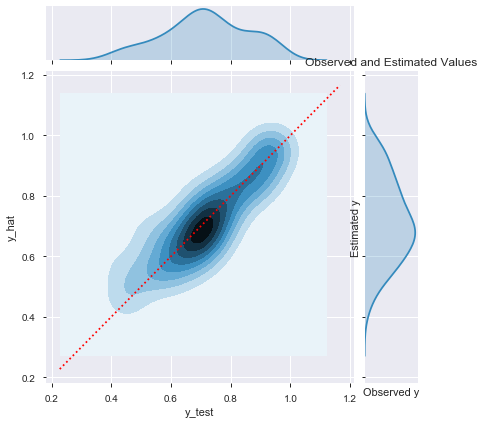

0.059597953609250826

In [247]:
rmse1 = evaluate_trace(trace1, X_test1, y_test1)
rmse1

In [56]:
# X_train1['y'] = y_train1

/Users/ellesmac/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [46]:
# read the sample set save when sampling

chain0= pd.read_csv('beta_normal/chain-0.csv')
chain1 = pd.read_csv('beta_normal/chain-1.csv')

# drop first 5000 samples for burn in
chain0 = chain1.iloc[5000:,:]
chain1 = chain1.iloc[5000:,:]
sample_df = pd.concat([chain0, chain1], axis=0, sort=False)



In [47]:
sample_df.head()

beta0  beta_num__0  beta_num__1  beta_num__2  beta_num__3  \
5000  0.694675     0.016233     0.026376    -0.007754     0.013464   
5001  0.690821     0.018836     0.019106     0.007184     0.014155   
5002  0.686909     0.021261     0.030310    -0.000335     0.016672   
5003  0.683812     0.027615     0.020294    -0.008777     0.018710   
5004  0.682188     0.027134     0.017624    -0.005825     0.016596   

      beta_num__4  beta_cat_logodds____0  beta_cat_logodds____1  \
5000     0.077990              -3.570418              -4.798383   
5001     0.074724              -3.506617              -4.542473   
5002     0.060024              -3.521659              -4.504199   
5003     0.067638              -3.674875              -3.735591   
5004     0.068002              -3.479913              -4.777913   

      beta_cat_logodds____2  beta_cat_logodds____3  beta_cat_logodds____4  \
5000              -4.647619              -4.424865              -3.144164   
5001              -5.387610              -4.476587              -4.416842   
5002              -4.245658              -4.344448              -3.149541   
5003              -4.512628              -3.495852              -2.992263   
5004              -3.726683              -3.766184              -2.850568   

      sigma_log__  beta_cat__0  beta_cat__1  beta_cat__2  beta_cat__3  \
5000    -2.791912     0.027374     0.008176     0.009493     0.011834   
5001    -2.739394     0.029125     0.010535     0.004552     0.011244   
5002    -2.825935     0.028702     0.010941     0.014124     0.012812   
5003    -2.865069     0.024726     0.023303     0.010851     0.029430   
5004    -2.867355     0.029889     0.008343     0.023507     0.022617   

      beta_cat__4     sigma  
5000     0.041322  0.061304  
5001     0.011928  0.064609  
5002     0.041109  0.059253  
5003     0.047777  0.056979  
5004     0.054652  0.056849

### Posterior y distribution

In [56]:
from IPython.core.pylabtools import figsize
figsize(9, 7)

def query_model(trace, X_test1, y_test1, sample_df, index):
     # Dictionary of all sampled values for each parameter
     
    print(pd.DataFrame(X_test1.iloc[index,:]))
    observation = pd.DataFrame(np.array(X_test1.iloc[index,:]).reshape(1, 10))
    observation.columns = ['beta_num__0', 'beta_num__1','beta_num__2', 'beta_num__3', 'beta_num__4',
                          'beta_cat__0', 'beta_cat__1', 'beta_cat__2', 'beta_cat__3','beta_cat__4']
    
    
    
    observation['beta0'] = 1
    

    
    var_weights = sample_df

    # get each coefficient for features
    weights = np.array(var_weights.ix[:, observation.columns])
    # multiple each coefficient and features and add them together to get y prediction
    estimates = np.dot(weights, np.array(observation).reshape(11, 1))
    
    

    plt.figure(figsize(8, 8))
    sns.distplot(estimates[:, 0], hist = True, kde = True,
                 hist_kws = {'edgecolor': 'k', 'color': 'navy'})
    
    # beta mean yhat line
    beta = pm.summary(trace)[['mean']].iloc[:11,].values
    beta0_hat = beta[0]
    betaj_hat = beta[1:]
    yhat = beta0_hat+np.dot(betaj_hat.T,np.array(observation.iloc[:,:10]).reshape(10, 1))
    
    plt.axvline(x= yhat, color = 'g', label = 'beta mean', linestyle = '--')
    
    # true y
    plt.axvline(x= y_test1.iloc[index,], color = 'r', label = 'true y')
    
    
    plt.annotate('$posterior \hat{ y}$', size = 15, xy=(np.percentile(estimates, 85), 30),xytext=(np.percentile(estimates, 99), 35),
            arrowprops=dict(facecolor='black', shrink=0.05))


    print('Average Estimate = %0.4f' % np.median(estimates))
    print('5%% Estimate = %0.4f    95%% Estimate = %0.4f' % (np.percentile(estimates, 5),
                                       np.percentile(estimates, 95)))
    # linear reg
    
    linear_reg(X_train1, y_train1, X_test1, y_test1)
    plt.axvline(x= lin_reg.predict(X_test1)[index], color = 'y', label = 'linear prediction', linestyle = '-.')
    
    plt.legend(loc='best', frameon=False, prop={'size': 12})
    plt.title('Density Plot for New Observation 316',fontweight="bold");
    plt.xlabel('Estimate'); plt.ylabel('Density');
    
    fig = plt.gcf() # to get the current figure...
    fig.savefig("posterior_y2.png") # and save it directly
    
    

In [49]:
# if directly using trace
# need to change here: var_weights = sample_df in query_mode function

# get all sampling beta values
df_beta0 = pd.DataFrame(trace1.get_values('beta0'))
df_beta_num = pd.DataFrame(trace1.get_values('beta_num'))
df_beta_cat = pd.DataFrame(trace1.get_values('beta_cat'))


beta_df = pd.concat([df_beta0, df_beta_num,  df_beta_cat], axis=1, sort=False)

beta_df.columns = ['beta0','beta_num__0', 'beta_num__1','beta_num__2', 'beta_num__3', 'beta_num__4',
                          'beta_cat__0', 'beta_cat__1', 'beta_cat__2', 'beta_cat__3','beta_cat__4']
    
beta_df.head()

beta0  beta_num__0  beta_num__1  beta_num__2  beta_num__3  beta_num__4  \
0  0.701713     0.036550     0.013333     0.008040     0.018680     0.059295   
1  0.704006     0.038041     0.017228     0.006171     0.018081     0.060880   
2  0.696644     0.019272     0.021853    -0.002366     0.016356     0.068327   
3  0.692033     0.021656     0.012139     0.006792     0.016540     0.072294   
4  0.685590     0.018103     0.023753     0.001826     0.017366     0.062921   

   beta_cat__0  beta_cat__1  beta_cat__2  beta_cat__3  beta_cat__4  
0     0.024152     0.006903     0.000442     0.004884     0.012017  
1     0.023841     0.003657     0.000474     0.005327     0.011729  
2     0.025591     0.005542     0.000717     0.013339     0.037400  
3     0.035060     0.020657     0.001152     0.012067     0.019103  
4     0.037843     0.013627     0.002279     0.021002     0.018586

                          361
GRE_Score            1.551817
TOEFL_Score          1.448239
SOP                  0.631683
LOR                  0.017289
CGPA                 1.593154
Research             1.000000
University_Rating_2  0.000000
University_Rating_3  0.000000
University_Rating_4  1.000000
University_Rating_5  0.000000


/Users/ellesmac/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
/Users/ellesmac/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:808: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  retval = getattr(retval, self.name)._getitem_axis(key, axis=i)
/Users/ellesmac/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will resu

Average Estimate = 0.9108
5% Estimate = 0.8963    95% Estimate = 0.9254


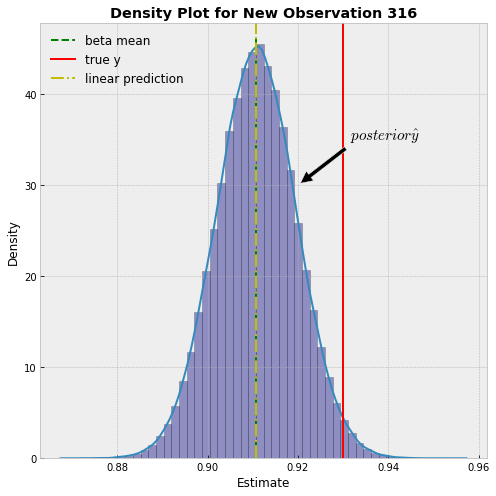

In [59]:
# can use sample_df(save from sampling) or beta_df (getting from trace1)
query_model(trace1, X_test1, y_test1, beta_df, 0);

In [51]:
# calculate rmse

def query_rmse(trace, x_test, y_test):
    pred = []
    for i in range(X_test1.shape[0]):
        observation = pd.DataFrame(np.array(X_test1.iloc[i,:]).reshape(1, 10))
        observation.columns = ['beta_num__0', 'beta_num__1','beta_num__2', 'beta_num__3', 'beta_num__4',
                          'beta_cat__0', 'beta_cat__1', 'beta_cat__2', 'beta_cat__3','beta_cat__4']
    
    
    
        observation['beta0'] = 1
        
        var_weights = sample_df

        weights = np.array(var_weights.ix[:, observation.columns])
        estimates = np.dot(weights, np.array(observation).reshape(11, 1))

    
        pred.append(np.median(estimates))
        
        
    mse = mean_squared_error(y_test1, np.array(pred))
    rmse = np.sqrt(mse)
    
    return rmse



In [236]:
bayes_rmse = query_rmse(trace1, X_test1, y_test1)
bayes_rmse

/Users/ellesmac/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  app.launch_new_instance()
/Users/ellesmac/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:808: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  retval = getattr(retval, self.name)._getitem_axis(key, axis=i)


0.059589792446965495

### MSE comparison
- Linear 
- Random Forest
- Bayesian Linear Model
- Elastic Net

The main benefit for Bayesian Machine Learning is getting posterior distribution of parameters instead of one estimate point. The predicting power for Bayesian model may not perform as well as traditional models. However, it is interesting that our Bayesian model perform well on predicting this dataset. 

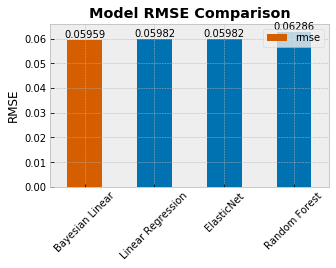

In [235]:
%matplotlib inline
plt.style.use('bmh')
colors = ['#348ABD', '#A60628', '#7A68A6', '#467821', '#D55E00', 
          '#CC79A7', '#56B4E9', '#009E73', '#F0E442', '#0072B2']

data = [linear_rmse, rf_rmse, bayes_rmse, elastic_rmse] 
  
# Create the pandas DataFrame 
rmse_result = pd.DataFrame(data, columns = ['rmse'], index = ['Linear Regression', 'Random Forest', 'Bayesian Linear', 'ElasticNet']) 

figsize(5, 3)
# Root mean squared error
ax = rmse_result.sort_values('rmse', ascending = True).plot.bar(y = 'rmse', color = ['#D55E00', colors[9], colors[9], colors[9]])
plt.title('Model RMSE Comparison',fontweight="bold"); plt.ylabel('RMSE');
# ax.legend(loc='best', frameon=False)
_ = plt.xticks(rotation=45)

rects = ax.patches
# Make some labels.
sort = rmse_result.sort_values('rmse', ascending = True)
for rect, label in zip(rects, sort['rmse']):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height, round(label, 5),
            ha='center', va='bottom')

    
fig = plt.gcf() # to get the current figure...
fig.savefig("posterior_y2.png") # and save it directly
    
   

## Compare pooling vs unpooling Model
### Group by University Rating

In [60]:
admission.groupby(['University_Rating']).mean()

Serial_No.   GRE_Score  TOEFL_Score       SOP      LOR   \
University_Rating                                                            
1                  281.558824  304.911765   100.205882  1.941176  2.426471   
2                  249.555556  309.134921   103.444444  2.682540  2.956349   
3                  247.574074  315.030864   106.314815  3.308642  3.401235   
4                  275.809524  323.304762   110.961905  4.000000  3.947619   
5                  207.753425  327.890411   113.438356  4.479452  4.404110   

                       CGPA  Research  Chance_of_Admit_  
University_Rating                                        
1                  7.798529  0.294118          0.562059  
2                  8.177778  0.293651          0.626111  
3                  8.500123  0.537037          0.702901  
4                  8.936667  0.780952          0.801619  
5                  9.278082  0.876712          0.888082

### <a name = pool></a>Complete pooling model
Treat all universities ranking same and estimate single admission chance. 

$ y = \alpha + \beta x_{i} + \epsilon_{i} $

Complete pooling model is developed treating all university rating same. We fit intercept with Normal distribution, and fit multinomial distribution for both numeric and categorical variables as priors. The main disadvantage of complete model is that it might “over smooth” when there is a pattern to the university rating. In other words, since complete pooling model treat different groups of university rating the same, it cannot interpret well if the groups have varies information 



In [61]:
df2_y = admission['Chance_of_Admit_'] # Target variable

df2 = admission.drop(columns = ['Serial_No.', 'Chance_of_Admit_']) 
df2.head()


GRE_Score  TOEFL_Score University_Rating  SOP  LOR   CGPA  Research
0        337          118                 4  4.5   4.5  9.65         1
1        324          107                 4  4.0   4.5  8.87         1
2        316          104                 3  3.0   3.5  8.00         1
3        322          110                 3  3.5   2.5  8.67         1
4        314          103                 2  2.0   3.0  8.21         0

In [62]:
# Scale five numerical features
from sklearn.model_selection import train_test_split

x_num2 = df2.iloc[:,[0,1,3,4,5]]
meanx2 = x_num2.mean().values
stdx2 = x_num2.std().values
x_num_scaled2 = ((x_num2-meanx2)/stdx2).values
df2.iloc[:,[0,1,3,4,5]] = x_num_scaled2

df2.head()

# 6 predictors (x's)
df2_feature = df2.iloc[:,[0,1,3,4,5,6]]
df2_feature.head()


GRE_Score  TOEFL_Score       SOP      LOR       CGPA  Research
0   1.817417     1.777086  1.136222  1.097845  1.775029         1
1   0.666481    -0.031569  0.631683  1.097845  0.485373         1
2  -0.041788    -0.524839 -0.377395  0.017289 -0.953088         1
3   0.489414     0.461700  0.127144 -1.063267  0.154692         1
4  -0.218855    -0.689262 -1.386473 -0.522989 -0.605873         0

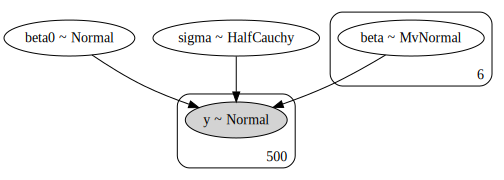

In [63]:
from pymc3 import Model, sample, Normal, HalfCauchy, Uniform, model_to_graphviz

rating = df2.University_Rating.values
admit = df2_y.values

with pm.Model() as pooled_model:

    beta0 = pm.Normal('beta0',0,sigma = 1e5)
    beta = pm.MvNormal('beta', mu = np.zeros(6), cov = np.identity(6), shape=6)
    sigma = pm.HalfCauchy('sigma', 5)

    theta = beta0 + pm.math.dot(beta , (df2_feature.values).T)

    y = pm.Normal('y', theta, sigma=sigma, observed=admit)
model_to_graphviz(pooled_model)

In [72]:
with pooled_model:
    pooled_trace = sample(10000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta, beta0]
Sampling 2 chains: 100%|██████████| 22000/22000 [00:47<00:00, 460.74draws/s]


point estimates of the slope and intercept for the complete pooling model

Each model for each university rating: different intercept, same slope  
$ y_{i} = \alpha_{[j]i} + \beta x_{i} + \epsilon_{i} $

In [67]:
# Remove index for University Rating 
rating = admission.University_Rating
rating_lookup = dict(zip(rating.unique(), range(len(rating.unique()))))
rating = admission.University_Rating.replace(rating_lookup).values

In [68]:
admission.groupby(['University_Rating']).size()

University_Rating
1     34
2    126
3    162
4    105
5     73
dtype: int64

This result is showing that groups which have less observation result in extreme estimate.Therefore, we would like to implement hierarchical model

### <a name = unpool></a>Unpooled Model

Unpooled model is running a separate regression for each group with varying intercepts and slopes. 
We used beta distribution for categorical variable, which is “Research”.

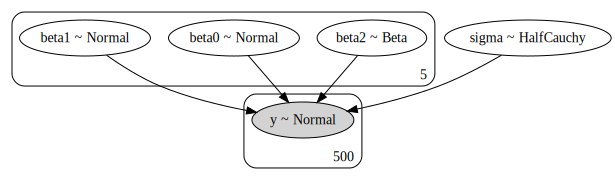

In [69]:
with Model() as unpooled_model3:

    beta0 = pm.Normal('beta0', 0, sd = 1, shape=5)
    beta1 = pm.Normal('beta1', mu = 0, sigma = 1, shape = (5))
    beta2 = pm.Beta('beta2', alpha =1, beta=1, shape = (5))
    sigma = HalfCauchy('sigma', 5)

    theta = beta0[rating] +  beta1[rating] *(df2_feature.GRE_Score.values 
                                     + df2_feature.TOEFL_Score.values + df2_feature.SOP.values 
                                     + df2_feature['LOR '].values+ df2_feature.CGPA.values) + beta2[rating] *(df2_feature.Research.values)

    y = Normal('y', theta, sigma=sigma, observed=admit)
model_to_graphviz(unpooled_model3)

In [70]:
with unpooled_model3:
    unpooled_trace = sample(10000, tune=1000)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc3:Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta2, beta1, beta0]
INFO:pymc3:NUTS: [sigma, beta2, beta1, beta0]
Sampling 2 chains: 100%|██████████| 22000/22000 [00:54<00:00, 400.12draws/s]


(<Figure size 432x360 with 1 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c20aae710>],
       dtype=object))

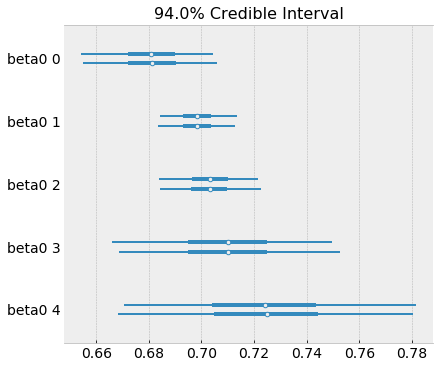

In [71]:
pm.forestplot(unpooled_trace, var_names = ['beta0'])

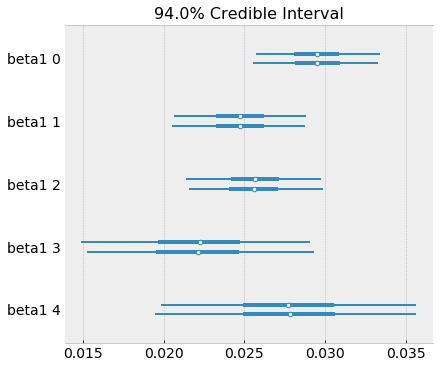

In [73]:
pm.forestplot(unpooled_trace, var_names = ['beta1']);

(<Figure size 432x360 with 1 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c20730278>],
       dtype=object))

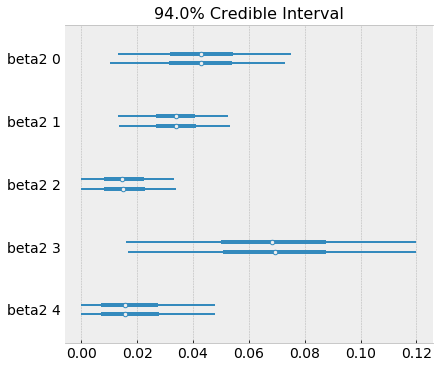

In [74]:
pm.forestplot(unpooled_trace, var_names = ['beta2'])

### <a name = heirarchical></a>Hierarchical Model
However, the number of observations of some University rating groups, such as rating 1 and 5, are relatively less compared to our groups. Therefore, hierarchical model is introduced to reduce the extreme value of unbalanced group size.<br>

Hierarchical model assumes that the parameters come from the common population distribution, which is typically self-evidence. Instead of fixing hyperparameter like unpooled model, their own higher prior (hyper prior) has given to them. The interesting point about hyperparameter is that they don’t change the likelihood function, but only influence on the posterior through prior on lower level of parameter. In other words, university ratings have some variation in mean, but the difference is little. <br>

Uniform distribution is used for beta distribution and normal and halfCauchy distribution is used for normal distribution as hyper prior.



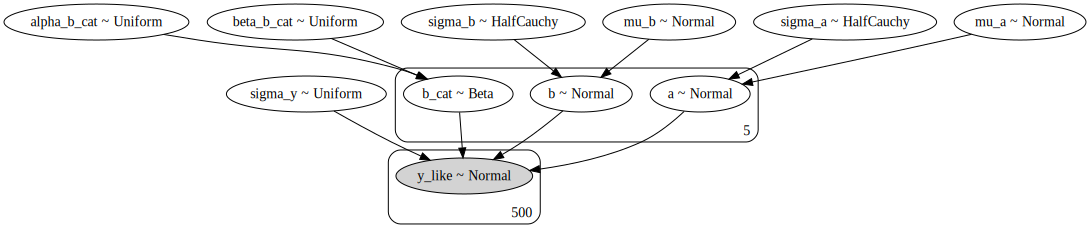

In [75]:
with Model() as varying_intercept_slope:

    # Priors
    mu_a = Normal('mu_a', mu=0., sigma=1e5)
    sigma_a = HalfCauchy('sigma_a', 5)
    
    mu_b = Normal('mu_b', mu=0., sigma=1e5)
    sigma_b = HalfCauchy('sigma_b', 5)
    
    alpha_b_cat = pm.Uniform('alpha_b_cat',0,5)
    beta_b_cat = pm.Uniform('beta_b_cat',0,5)
    

    # Random intercepts
    a = Normal('a', mu=mu_a, sigma=sigma_a, shape=5)
    # Random slopes
    b = pm.Normal('b', mu=mu_b, sigma=sigma_b, shape=5)
    b_cat = pm.Beta('b_cat', alpha = alpha_b_cat, beta = beta_b_cat, shape = 5)

    # Model error
    sigma_y = Uniform('sigma_y', lower=0, upper=100)

    # Expected value
    y_hat = a[rating] + b[rating] * (df2_feature.GRE_Score.values 
                                     + df2_feature.TOEFL_Score.values + df2_feature.SOP.values 
                                     + df2_feature['LOR '].values+ df2_feature.CGPA.values )+ b_cat[rating]*(df2_feature.Research.values)

    # Data likelihood
    y_like = Normal('y_like', mu=y_hat, sigma=sigma_y, observed=admit)

model_to_graphviz(varying_intercept_slope)


In [76]:
with varying_intercept_slope:
    varying_trace = sample(10000, tune=1000)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc3:Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_y, b_cat, b, a, beta_b_cat, alpha_b_cat, sigma_b, mu_b, sigma_a, mu_a]
INFO:pymc3:NUTS: [sigma_y, b_cat, b, a, beta_b_cat, alpha_b_cat, sigma_b, mu_b, sigma_a, mu_a]
Sampling 2 chains: 100%|██████████| 22000/22000 [02:39<00:00, 138.16draws/s]
There were 971 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 971 divergences after tuning. Increase `target_accept` or reparameterize.
There were 569 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 569 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


(<Figure size 432x360 with 1 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c22a1c390>],
       dtype=object))

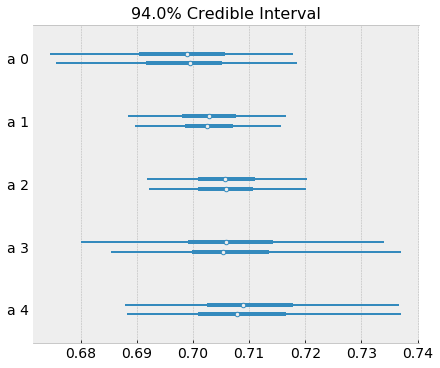

In [77]:
pm.forestplot(varying_trace, var_names = ['a'])

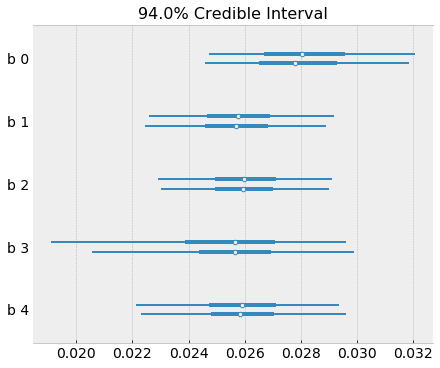

In [78]:
pm.forestplot(varying_trace, var_names = ['b']);

(<Figure size 432x360 with 1 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c1dc21f28>],
       dtype=object))

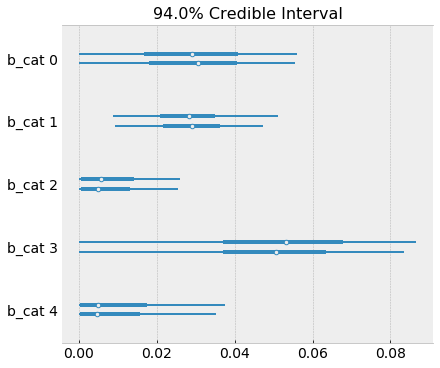

In [79]:
pm.forestplot(varying_trace, var_names = ['b_cat'])

## <a name = compare></a>Model Comarison

### <a name = i&s></a>Intercept and Slope comparison
We can see that Hierarchical model did relieve the extreme value in each group compared to unpooled model

In [253]:
# beta1 and b are the coefficient of numerical feartures, it can be changed to other coefficients
unpool_coef = ['beta0', 'beta1', 'beta2']
varing_coef = ['a', 'b', 'b_cat']

unpool2_list = [unpooled_trace[i].mean(axis=0) for i in unpool_coef]
varying_list = [varying_trace[i].mean(axis=0) for i in varing_coef]

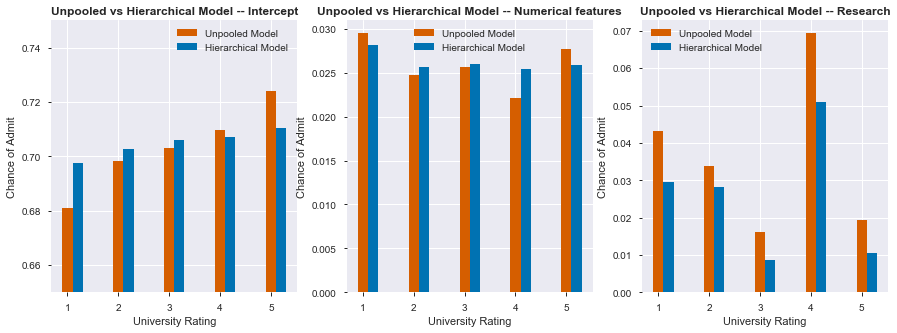

In [262]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows = 1, ncols = 3, figsize = (15,5))
x = []
partial_x = []
for i in range(1,6):
    x.append(i) 
    partial_x.append(i+.2)
ax_list = [ax1, ax2, ax3]
label_list = ['Intercept', 'Numerical features', 'Research']
for ax, unpool2, varying, label in zip(ax_list, unpool2_list, varying_list, label_list):
    ax.bar(x,unpool2, color = colors[4], width = .2)
    ax.bar(partial_x,varying, color = colors[9], width = .2)
    ax.set_title("Unpooled vs Hierarchical Model -- "+str(label), fontweight="bold")
    ax.set_xlabel('University Rating')
    ax.set_ylabel('Chance of Admit')
    ax.legend(labels = ['Unpooled Model','Hierarchical Model'])
    if (ax is ax1):
      
        ax.set_ylim([0.65, 0.75])

    
fig = plt.gcf() # to get the current figure...
fig.savefig("performance.png") # and save it directly


### <a name = mean></a>Mean and SD comarison

In [86]:
rating_list = ['Rating1','Rating2','Rating3','Rating4','Rating5']
unpooled_estimates = pd.Series(unpooled_trace['beta0'].mean(axis=0), index = rating_list)
unpooled_se = pd.Series(unpooled_trace['beta0'].std(axis=0), index = rating_list)
print(unpooled_estimates)
print(unpooled_se)

Rating1    0.707659
Rating2    0.705521
Rating3    0.700454
Rating4    0.727435
Rating5    0.708553
dtype: float64
Rating1    0.007805
Rating2    0.006083
Rating3    0.007007
Rating4    0.009772
Rating5    0.012791
dtype: float64


In [320]:
varying_estimates = pd.Series(varying_trace['a'].mean(axis=0), index = rating_list)
varying_se = pd.Series(varying_trace['a'].std(axis=0), index = rating_list)
print(varying_estimates)
print(varying_se)

Rating 1    0.697197
Rating 2    0.702745
Rating 3    0.705918
Rating 4    0.707033
Rating 5    0.710256
dtype: float64
Rating 1    0.011749
Rating 2    0.007115
Rating 3    0.007559
Rating 4    0.013166
Rating 5    0.012993
dtype: float64


### <a name = waic></a>WAIC comparison
We use WAIC to evaluate the model performance, and complete pooling model turns out to be the best model with the least WAIC score. We can be concluded that university rating does not significantly influence on the prediction of the chance of admit 


In [294]:
import arviz as az
compare = az.compare({'pool':pooled_trace, 'unpool':unpooled_trace, 'hierarchical':varying_trace},
                    method='BB-pseudo-BMA')
compare

rank     waic   p_waic   d_waic       weight       se      dse  \
pool            0 -1382.54  9.44397        0     0.998812  47.5726        0   
hierarchical    1 -1308.74  11.2697  73.8056  0.000102085  45.6283  20.4937   
unpool          2 -1305.95  13.7005  76.5929   0.00108562  45.9684  21.2361   

             warning waic_scale  
pool            True   deviance  
hierarchical    True   deviance  
unpool          True   deviance